In [95]:
import openpyxl
import pandas as pd
import numpy as np
import os
from pandas import read_excel
from tqdm import tqdm_notebook
from itertools import count
from operator import index, indexOf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.cuda.comm
from torch.autograd import Variable

# GPU 학습 세팅

In [96]:
torch.cuda.is_available()

True

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data 전처리

In [98]:
#Training/Test ratio = 8:2
Train_ratio = 0.8
Test_ratio = 0.2

In [99]:
def test(excel_path, year):
    data = read_excel(f'{excel_path}')
    data = data.astype({'계약년월':'string'})
    # print(data.info())
    current_apartname = ""
    current_df = []
    current_ms= []
    all_ms= ["01","02","03","04","05","06","07","08","09","10","11","12"]
    new_d = []
    for ind in data.index:
        ym = str(data["계약년월"][ind])
        #ym_format = ym[:4] + "-" + ym[4:]
        ym_format = ym[:]
        data.at[ind,"계약년월"] = ym_format
        # data["계약년월"][ind].values = ym_format

        if ind == 0:
            print("ind == 0")
            current_apartname = data["단지명"][ind]
        if current_apartname == data["단지명"][ind]:
            m = str(data["계약년월"][ind])
            if m[4:] not in current_ms:
                current_ms.append(m[5:])
        if ind == len(data)-1:
            print(current_apartname)
            for i in all_ms:
                if i not in current_ms:
                    d = {'단지명':current_apartname,'계약년월':f"{year}{i}-1",'x':data["x"][ind], 'y':data["y"][ind] }
                    new_d.append(d)
        else:
            if current_apartname != data["단지명"][ind+1]:
                for i in all_ms:
                    if i not in current_ms:
                        # d = {'단지명':current_apartname,'계약년월':int(f"{year}-{i}"),'x':data["x"][ind], 'y':data["y"][ind] }
                        d = {'단지명':current_apartname,'계약년월':f"{year}{i}",'x':data["x"][ind], 'y':data["y"][ind] }
                        new_d.append(d)

                current_apartname = data["단지명"][ind+1]
                current_ms=[]

    new_df= pd.DataFrame(new_d)
    data = pd.concat([data,new_df])
    data.sort_values(['단지명', '계약년월'], ascending=[True, True], inplace=True)

    # 가격 데이터 빈 곳이 있으면 자동으로 linear 그래프 이용해서 채워줌
    for i in tqdm_notebook(data.filter(['거래금액(만원)']).columns):
        data[i] = data[i].interpolate()
    return data

In [100]:
#df = test('test.xlsx', '2015')
#df.drop_duplicates()
data = read_excel('test.xlsx')
df = df.dropna()
df.head(10)

,시군구,번지,본번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,x,y
0,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201501,11.0,60000.0,5.0,1988.0,1.414349e+07,4.506431e+06
1,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201502,1.0,62500.0,5.0,1988.0,1.414349e+07,4.506431e+06
2,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201503,3.0,65000.0,5.0,1988.0,1.414349e+07,4.506431e+06
3,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201503,7.0,62500.0,2.0,1988.0,1.414349e+07,4.506431e+06
4,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201504,7.0,64000.0,2.0,1988.0,1.414349e+07,4.506431e+06
5,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201505,7.0,65000.0,2.0,1988.0,1.414349e+07,4.506431e+06
6,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201506,7.0,66000.0,2.0,1988.0,1.414349e+07,4.506431e+06
7,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201507,7.0,67000.0,2.0,1988.0,1.414349e+07,4.506431e+06
8,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201508,16.0,68000.0,6.0,1988.0,1.414349e+07,4.506431e+06
9,서울특별시 강남구 개포동,655-2,655.0,개포2차현대아파트(220),77.75,201509,16.0,69000.0,6.0,1988.0,1.414349e+07,4.506431e+06


In [101]:
x = df.iloc[1:,5:6]
y = df.iloc[1:,7:8]

In [102]:
train_x = x.iloc[0:int(len(df)*Train_ratio),:]
train_y = y.iloc[0:int(len(df)*Train_ratio),:]
test_x = x.iloc[int(len(df)*Train_ratio):,:]
test_y = y.iloc[int(len(df)*Train_ratio):,:]

In [103]:
# Normalizing, 둘다 학습하여 성능 비교
minmax = MinMaxScaler()
standard = StandardScaler()

train_x = minmax.fit_transform(train_x)
train_y = minmax.fit_transform(train_y)
test_x = minmax.fit_transform(test_x)
test_y = minmax.fit_transform(test_y)

In [104]:
# Check Data pre-processing
print("Training shape :", train_x.shape, train_y.shape)
print("Test shape :", test_x.shape, test_y.shape)

Training shape : (48, 1) (48, 1)
Test shape : (12, 1) (12, 1)


In [105]:
# Numpy array 상태로 학습 불가 -> Torch Variable 형태로 변경(data / grad / grad_fn)
train_x_tensor = Variable(torch.Tensor(train_x))
train_y_tensor = Variable(torch.Tensor(train_y))

print("After torch variable shape_Train :", train_x_tensor.shape, train_y_tensor.shape)

After torch variable shape_Train : torch.Size([48, 1]) torch.Size([48, 1])


In [106]:
test_x_tensor = Variable(torch.Tensor(test_x))
test_y_tensor = Variable(torch.Tensor(test_y))

print("After torch variable shape_Test :", test_x_tensor.shape, test_y_tensor.shape)

After torch variable shape_Test : torch.Size([12, 1]) torch.Size([12, 1])


In [107]:
train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))

train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))

test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))

test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

print(train_x_tensor_final.shape, test_x_tensor_final.shape)

torch.Size([48, 1, 1]) torch.Size([12, 1, 1])


# LSTM network modeling

In [108]:
class LSTM_Jun(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) : 
        super(LSTM_Jun, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.layer_1 = nn.Linear(hidden_size, 256)
        self.layer_2 = nn.Linear(256,256)
        self.layer_3 = nn.Linear(256,128)
        self.layer_out = nn.Linear(128, num_classes)
        self.relu = nn.ReLU() #Activation Func

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Hidden State
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Internal Process States

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size) # Reshaping the data for starting LSTM network
        out = self.relu(hn) #pre-processing for first layer
        out = self.layer_1(out) # first layer
        out = self.relu(out) # activation func relu
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out)
        out = self.relu(out)
        out = self.layer_out(out) #Output layer

        return out

In [109]:
# Code Main

num_epochs = 100000
learning_rate = 0.0005

input_size = int(len(x.columns))
hidden_size = 2 # number of features in hidden state

num_layers = 1
num_classes = int(len(y.columns))


LSTM_Jun = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, train_x_tensor_final.shape[1]).to(device)


loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_Jun.parameters(), lr = learning_rate)


for epoch in range(num_epochs) : 
    outputs = LSTM_Jun.forward(train_x_tensor_final.to(device))
    optimizer.zero_grad()

    loss = loss_function(outputs, train_y_tensor.to(device))
    loss.backward()

    optimizer.step() # improve from loss = back propagation

    if epoch % 200 == 0 :
        print("Epoch : %d, loss : %1.5f" % (epoch, loss.item()))

 

# Estimated Value

test_predict = LSTM_Jun(train_x_tensor_final.to(device)) #Forward Pass
predict_data = test_predict.data.detach().cpu() #numpy conversion
predict_data = minmax.inverse_transform(predict_data) #inverse normalization(Min/Max)


# Real Value

real_data = train_y_tensor.data # Real value
real_data = minmax.inverse_transform(real_data) #inverse normalization

Epoch : 0, loss : 0.42269
Epoch : 200, loss : 0.00643
Epoch : 400, loss : 0.00637
Epoch : 600, loss : 0.00630
Epoch : 800, loss : 0.00626
Epoch : 1000, loss : 0.00622
Epoch : 1200, loss : 0.00614
Epoch : 1400, loss : 0.00604
Epoch : 1600, loss : 0.00592
Epoch : 1800, loss : 0.00578
Epoch : 2000, loss : 0.00560
Epoch : 2200, loss : 0.00537
Epoch : 2400, loss : 0.00691
Epoch : 2600, loss : 0.00458
Epoch : 2800, loss : 0.00407
Epoch : 3000, loss : 0.00379
Epoch : 3200, loss : 0.00358
Epoch : 3400, loss : 0.00312
Epoch : 3600, loss : 0.00273
Epoch : 3800, loss : 0.00231
Epoch : 4000, loss : 0.00214
Epoch : 4200, loss : 0.00180
Epoch : 4400, loss : 0.00139
Epoch : 4600, loss : 0.00147
Epoch : 4800, loss : 0.00119
Epoch : 5000, loss : 0.00114
Epoch : 5200, loss : 0.00089
Epoch : 5400, loss : 0.00079
Epoch : 5600, loss : 0.00092
Epoch : 5800, loss : 0.00114
Epoch : 6000, loss : 0.00076
Epoch : 6200, loss : 0.00060
Epoch : 6400, loss : 0.00106
Epoch : 6600, loss : 0.00061
Epoch : 6800, loss : 

Epoch : 55000, loss : 0.00020
Epoch : 55200, loss : 0.00029
Epoch : 55400, loss : 0.00019
Epoch : 55600, loss : 0.00019
Epoch : 55800, loss : 0.00021
Epoch : 56000, loss : 0.00030
Epoch : 56200, loss : 0.00019
Epoch : 56400, loss : 0.00021
Epoch : 56600, loss : 0.00025
Epoch : 56800, loss : 0.00021
Epoch : 57000, loss : 0.00019
Epoch : 57200, loss : 0.00021
Epoch : 57400, loss : 0.00021
Epoch : 57600, loss : 0.00017
Epoch : 57800, loss : 0.00017
Epoch : 58000, loss : 0.00018
Epoch : 58200, loss : 0.00019
Epoch : 58400, loss : 0.00015
Epoch : 58600, loss : 0.00017
Epoch : 58800, loss : 0.00017
Epoch : 59000, loss : 0.00017
Epoch : 59200, loss : 0.00018
Epoch : 59400, loss : 0.00014
Epoch : 59600, loss : 0.00015
Epoch : 59800, loss : 0.00031
Epoch : 60000, loss : 0.00019
Epoch : 60200, loss : 0.00015
Epoch : 60400, loss : 0.00013
Epoch : 60600, loss : 0.00014
Epoch : 60800, loss : 0.00019
Epoch : 61000, loss : 0.00013
Epoch : 61200, loss : 0.00014
Epoch : 61400, loss : 0.00015
Epoch : 61

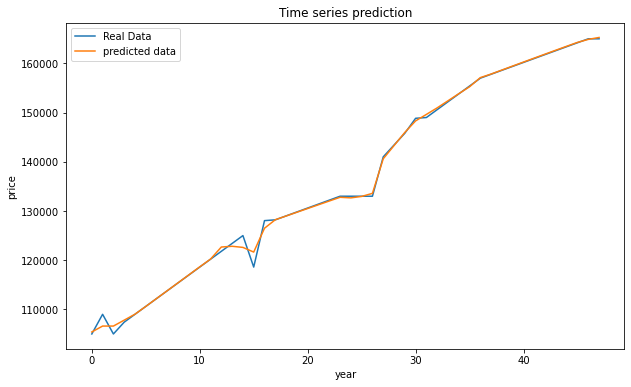

In [111]:
#Figure

plt.figure(figsize = (10,6)) # Plotting
plt.plot(real_data, label = 'Real Data')
plt.plot(predict_data, label = 'predicted data')
plt.title('Time series prediction')
plt.xlabel('year')
plt.ylabel('price')
plt.legend()

plt.show()

In [122]:
data = read_excel('test2.xlsx')
dt = data
dt

,Date,거래금액(만원)
0,202001,165000
1,202002,165000
2,202003,170000
3,202004,172000
4,202005,168000
5,202006,170000
6,202007,172000
7,202008,172000
8,202009,175000
9,202010,174000


In [123]:
x = dt.iloc[1:,0:1]
y = dt.iloc[1:,1:2]

minmax = MinMaxScaler()
standard = StandardScaler()

x_all = minmax.fit_transform(x)
y_all = minmax.fit_transform(y)

# Check Data pre-processing
print("x shape :", x_all.shape)
print("y shape :", y_all.shape)

x shape : (11, 1)
y shape : (11, 1)


In [124]:
def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_lengthq_length)]
            res.append(tmp)
            
    return res

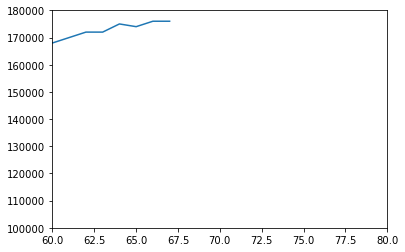

In [135]:
x_all = create_sequences1(x_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
x_all = torch.tensor(x_all).float()
y_all = torch.tensor(y_all).float()

plt.plot([56,57,58,59,60,61,62,63,64,65,66,67], [165000,165000,170000,172000,168000,170000,172000,172000,175000,174000,176000,176000])
plt.xlim([60, 80])
plt.ylim([100000,180000])
plt.show()

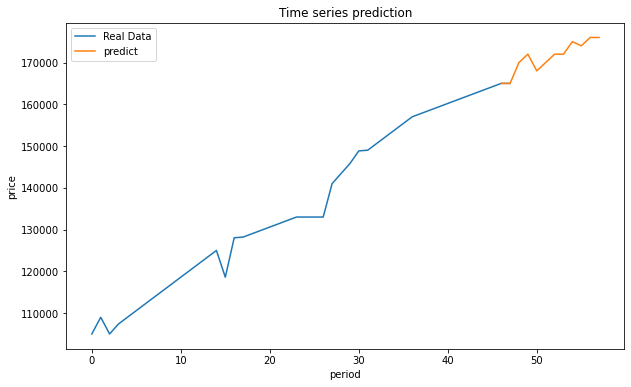

In [138]:
plt.figure(figsize = (10,6)) # Plotting
plt.plot(real_data, label = 'Real Data')
plt.plot([46,47,48,49,50,51,52,53,54,55,56,57], [165000,165000,170000,172000,168000,170000,172000,172000,175000,174000,176000,176000], label= 'predict')
# plt.xlim([60, 80])
# plt.ylim([100000,180000])
plt.title('Time series prediction')
plt.xlabel('period')
plt.ylabel('price')
plt.legend()

plt.show()